<a href="https://colab.research.google.com/github/michaelyang-21/pka/blob/main/solubility_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Solubility**

Restart runtime completely when using a new dataset

Importing important packages and functions

In [ ]:
!pip install rdkit
!pip install deepchem

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.2/693.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 20.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1


In [ ]:
import os, math
import pandas as pd
import numpy as np

import rdkit
import deepchem as dc

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

Read training files

Testing files can also be read here if they are part of the training file. If they are separate, read them later

In [ ]:
# df = pd.read_csv("delaney-processed.csv")
# df = pd.read_csv("curated-solubility-dataset.csv")
df = pd.read_csv("aqsol_llinas_train.csv")

Featurizer

In [ ]:
rdkit_featurizer = dc.feat.RDKitDescriptors(use_fragment=False, ipc_avg=False)
features = rdkit_featurizer(df.smiles) # with one molecule

[20:33:02] WARNING: not removing hydrogen atom without neighbors
[20:33:02] WARNING: not removing hydrogen atom without neighbors
[20:33:02] WARNING: not removing hydrogen atom without neighbors
[20:33:03] WARNING: not removing hydrogen atom without neighbors
[20:33:03] WARNING: not removing hydrogen atom without neighbors
[20:33:03] WARNING: not removing hydrogen atom without neighbors
[20:33:03] WARNING: not removing hydrogen atom without neighbors
[20:33:03] WARNING: not removing hydrogen atom without neighbors
[20:33:03] WARNING: not removing hydrogen atom without neighbors
[20:33:05] WARNING: not removing hydrogen atom without neighbors
[20:33:05] WARNING: not removing hydrogen atom without neighbors
[20:33:05] WARNING: not removing hydrogen atom without neighbors
[20:33:05] WARNING: not removing hydrogen atom without neighbors
[20:33:05] WARNING: not removing hydrogen atom without neighbors
[20:33:05] WARNING: not removing hydrogen atom without neighbors
[20:33:05] WARNING: not r

In [ ]:
features.shape

(9860, 124)

In [ ]:
# Creating the feature dataset

column_names = rdkit_featurizer.descriptors

df0 = pd.DataFrame(data=features)
df0.columns = column_names

# adding molecule ids and solubility columns
# 'ESOL' for delaney and 'Solubility' for Aqsoldb
df0["smiles"] = df.smiles
df0["y"] = df.y

In [ ]:
df0.columns

Index(['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex',
       'MinEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt',
       'NumValenceElectrons', 'NumRadicalElectrons',
       ...
       'NumHeteroatoms', 'NumRotatableBonds', 'NumSaturatedCarbocycles',
       'NumSaturatedHeterocycles', 'NumSaturatedRings', 'RingCount', 'MolLogP',
       'MolMR', 'smiles', 'y'],
      dtype='object', length=126)

In [ ]:
df0.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,smiles,y
0,2.296832,2.296832,0.000000,0.000000,0.259676,392.510,346.142,391.281363,142.0,0.0,...,2.0,17.0,0.0,0.0,0.0,0.0,3.9581,102.4454,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127
1,11.435093,11.435093,0.006296,0.006296,0.644215,169.183,162.127,169.052764,62.0,0.0,...,2.0,0.0,0.0,0.0,0.0,3.0,2.4055,51.9012,O=C1Nc2cccc3cccc1c23,-3.254767
2,10.074698,10.074698,0.652222,0.652222,0.546650,140.569,135.529,140.002892,46.0,0.0,...,2.0,1.0,0.0,0.0,0.0,1.0,2.1525,36.8395,Clc1ccc(C=O)cc1,-2.177078
3,11.573312,11.573312,0.000000,-1.369330,0.136407,756.226,713.890,754.227281,264.0,0.0,...,7.0,10.0,0.0,0.0,0.0,6.0,8.1161,200.7106,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409
4,5.440876,5.440876,0.383760,0.383760,0.490100,422.525,392.285,422.220557,164.0,0.0,...,6.0,12.0,0.0,4.0,4.0,6.0,2.4854,119.0760,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_absolute_error
import lightgbm as lgb
from lightgbm import Dataset

In [ ]:
y = df0.y
X = df0.drop(columns=["smiles", "y"])

**Training with one file** (training with one training csv file)

In [ ]:
import math
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from scipy import stats

# Split the data into training and combined validation/testing set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the combined validation/testing set into validation and testing set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Define the LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting': 'gbdt',
    'num_leaves': 40,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# Convert the data to LightGBM Dataset format
data = lgb.Dataset(X_train_val, label=y_train_val)

# Perform cross-validation
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
mse_scores = []
mae_scores = []

for train_index, val_index in kf.split(X_train_val):
    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)

    model = lgb.train(params, train_data, num_boost_round=500, valid_sets=[train_data, val_data], early_stopping_rounds=10)

    y_val_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_val_pred)
    mae = mean_absolute_error(y_val, y_val_pred)

    mse_scores.append(mse)
    mae_scores.append(mae)

avg_mse = np.mean(mse_scores)
avg_mae = np.mean(mae_scores)

print("Average Mean Squared Error:", avg_mse)
print("Average Mean Absolute Error:", avg_mae)


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's rmse: 1.55395	valid_1's rmse: 1.45317
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's rmse: 1.41092	valid_1's rmse: 1.3239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's rmse: 1.28278	valid_1's rmse: 1.20814
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's rmse: 1.17825	valid_1's rmse: 1.11764
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's rmse: 1.07458	valid_1's rmse: 1.02703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	training's rmse: 0.991341	valid_1's rmse: 0.965768
[Ligh

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's rmse: 1.37592	valid_1's rmse: 1.477
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's rmse: 1.25527	valid_1's rmse: 1.33922
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's rmse: 1.1561	valid_1's rmse: 1.24185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's rmse: 1.05817	valid_1's rmse: 1.1317
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	training's rmse: 0.982411	valid_1's rmse: 1.04963
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	training's rmse: 0.901061	valid_1's rmse: 0.9574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8]	training's rmse: 0.838522	valid_1's rmse: 0.89298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9]	training's rmse: 0.777671	v

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	training's rmse: 0.365131	valid_1's rmse: 0.471295
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21]	training's rmse: 0.349602	valid_1's rmse: 0.462088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22]	training's rmse: 0.336116	valid_1's rmse: 0.454506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23]	training's rmse: 0.324604	valid_1's rmse: 0.447176
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[24]	training's rmse: 0.314041	valid_1's rmse: 0.440196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[25]	training's rmse: 0.304095	valid_1's rmse: 0.433136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[26]	training's rmse: 0.292754	valid_1's rmse: 0.425438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[27]	tra

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14]	training's rmse: 0.532543	valid_1's rmse: 0.6166
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15]	training's rmse: 0.497376	valid_1's rmse: 0.58526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16]	training's rmse: 0.464213	valid_1's rmse: 0.556926
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17]	training's rmse: 0.43517	valid_1's rmse: 0.535183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18]	training's rmse: 0.411376	valid_1's rmse: 0.520523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19]	training's rmse: 0.388625	valid_1's rmse: 0.503595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	training's rmse: 0.368956	valid_1's rmse: 0.490868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21]	trainin

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[3]	training's rmse: 1.26327	valid_1's rmse: 1.28714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's rmse: 1.16144	valid_1's rmse: 1.20133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's rmse: 1.05908	valid_1's rmse: 1.10057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	training's rmse: 0.97757	valid_1's rmse: 1.03291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	training's rmse: 0.892611	valid_1's rmse: 0.954806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8]	training's rmse: 0.826809	valid_1's rmse: 0.901788
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9]	training's rmse: 0.767159	valid_1's rmse: 0.856042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	training's rmse: 0.704639	valid_1's rmse: 0.797517
[LightGBM] [Warning] No further splits wi

**Training with a training csv and testing csv** (2 files)

In [ ]:
import math
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from scipy import stats

# Split the data into training and combined validation/testing set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting': 'gbdt',
    'num_leaves': 40,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# Convert the data to LightGBM Dataset format
data = lgb.Dataset(X_train_val, label=y_train_val)

# Perform cross-validation
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
mse_scores = []
mae_scores = []

for train_index, val_index in kf.split(X_train_val):
    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)

    model = lgb.train(params, train_data, num_boost_round=1000, valid_sets=[train_data, val_data], early_stopping_rounds=10)

    y_val_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_val_pred)
    mae = mean_absolute_error(y_val, y_val_pred)

    mse_scores.append(mse)
    mae_scores.append(mae)

avg_mse = np.mean(mse_scores)
avg_mae = np.mean(mae_scores)

print("Average Mean Squared Error:", avg_mse)
print("Average Mean Absolute Error:", avg_mae)

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	training's rmse: 2.20954	valid_1's rmse: 2.18584
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 2.05406	valid_1's rmse: 2.04017
[3]	training's rmse: 1.91685	valid_1's rmse: 1.91135
[4]	training's rmse: 1.7934	valid_1's rmse: 1.79692
[5]	training's rmse: 1.69311	valid_1's rmse: 1.70558
[6]	training's rmse: 1.5973	valid_1's rmse: 1.61918
[7]	training's rmse: 1.51232	valid_1's rmse: 1.54163
[8]	training's rmse: 1.43911	valid_1's rmse: 1.47757
[9]	training's rmse: 1.37637	valid_1's rmse: 1.42414
[10]	training's rmse: 1.32139	valid_1's rmse: 1.37841
[11]	training's rmse: 1.26962	valid_1's rmse: 1.33902
[12]	training's rmse: 1.22543	valid_1's rmse: 1.3036
[13]	training's rmse: 1.18689	valid_1's rmse: 1.27318
[14]	training's rmse: 1.15241	valid_1's rmse: 1.24575
[15]	training's rmse: 1.12166	

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	training's rmse: 2.20831	valid_1's rmse: 2.19582
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 2.05349	valid_1's rmse: 2.05086
[3]	training's rmse: 1.9166	valid_1's rmse: 1.92497
[4]	training's rmse: 1.79609	valid_1's rmse: 1.81689
[5]	training's rmse: 1.6956	valid_1's rmse: 1.72343
[6]	training's rmse: 1.59942	valid_1's rmse: 1.63753
[7]	training's rmse: 1.51379	valid_1's rmse: 1.56444
[8]	training's rmse: 1.43992	valid_1's rmse: 1.50203
[9]	training's rmse: 1.37489	valid_1's rmse: 1.44548
[10]	training's rmse: 1.31841	valid_1's rmse: 1.3991
[11]	training's rmse: 1.26735	valid_1's rmse: 1.35978
[12]	training's rmse: 1.22406	valid_1's rmse: 1.32698
[13]	training's rmse: 1.18563	valid_1's rmse: 1.29867
[14]	training's rmse: 1.15191	valid_1's rmse: 1.27541
[15]	training's rmse: 1.12024	

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	training's rmse: 2.22004	valid_1's rmse: 2.22919
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 2.06324	valid_1's rmse: 2.07675
[3]	training's rmse: 1.92416	valid_1's rmse: 1.94003
[4]	training's rmse: 1.80213	valid_1's rmse: 1.82254
[5]	training's rmse: 1.6949	valid_1's rmse: 1.71834
[6]	training's rmse: 1.59932	valid_1's rmse: 1.62684
[7]	training's rmse: 1.51573	valid_1's rmse: 1.55149
[8]	training's rmse: 1.44264	valid_1's rmse: 1.48542
[9]	training's rmse: 1.37915	valid_1's rmse: 1.4266
[10]	training's rmse: 1.32334	valid_1's rmse: 1.37481
[11]	training's rmse: 1.27268	valid_1's rmse: 1.32922
[12]	training's rmse: 1.22806	valid_1's rmse: 1.29208
[13]	training's rmse: 1.19005	valid_1's rmse: 1.26174
[14]	training's rmse: 1.15549	valid_1's rmse: 1.23496
[15]	training's rmse: 1.12367

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	training's rmse: 2.20352	valid_1's rmse: 2.21221
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 2.05108	valid_1's rmse: 2.05906
[3]	training's rmse: 1.9149	valid_1's rmse: 1.92698
[4]	training's rmse: 1.7953	valid_1's rmse: 1.81344
[5]	training's rmse: 1.69523	valid_1's rmse: 1.71974
[6]	training's rmse: 1.60076	valid_1's rmse: 1.63315
[7]	training's rmse: 1.51786	valid_1's rmse: 1.55269
[8]	training's rmse: 1.44476	valid_1's rmse: 1.48681
[9]	training's rmse: 1.38117	valid_1's rmse: 1.43093
[10]	training's rmse: 1.32303	valid_1's rmse: 1.37868
[11]	training's rmse: 1.27262	valid_1's rmse: 1.33381
[12]	training's rmse: 1.22711	valid_1's rmse: 1.29761
[13]	training's rmse: 1.18709	valid_1's rmse: 1.26348
[14]	training's rms

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	training's rmse: 2.19815	valid_1's rmse: 2.24716
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 2.04424	valid_1's rmse: 2.09516
[3]	training's rmse: 1.90945	valid_1's rmse: 1.96357
[4]	training's rmse: 1.78905	valid_1's rmse: 1.84725
[5]	training's rmse: 1.68763	valid_1's rmse: 1.75313
[6]	training's rmse: 1.59307	valid_1's rmse: 1.66239
[7]	training's rmse: 1.50999	valid_1's rmse: 1.58329
[8]	training's rmse: 1.43782	valid_1's rmse: 1.5151
[9]	training's rmse: 1.3745	valid_1's rmse: 1.45636
[10]	training's rmse: 1.31782	valid_1's rmse: 1.40392
[11]	training's rmse: 1.26781	valid_1's rmse: 1.35859
[12]	training's rmse: 1.22398	valid_1's rmse: 1.32261
[13]	training's rmse: 1.18465	valid_1's rmse: 1.29037
[14]	training's rmse: 1.15112	valid_1's rmse: 1.26228
[15]	training's rmse: 1.1204	

Continue ...

Distribution of MSE scores during cross-validation

In [ ]:
mse_scores

[1.0039481742953598,
 1.0442713716617733,
 0.9940469310696906,
 0.9528201790555939,
 1.032161947482173]

<Axes: ylabel='Density'>

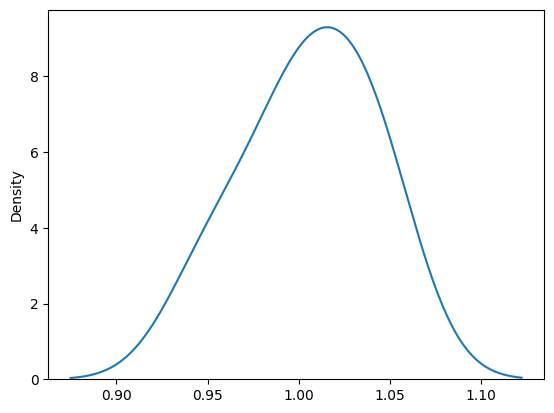

In [ ]:
import seaborn as sns

#create density curve
sns.kdeplot(mse_scores)

**If you have a test set, run this**

If you do not have a test set, do NOT run this code! Skip to "Training the Final Model"

Read test set (csv only)

In [ ]:
df = pd.read_csv("llinas2020_set2_test.csv") # or any test set here

In [ ]:
rdkit_featurizer = dc.feat.RDKitDescriptors(use_fragment=False, ipc_avg=False)
features = rdkit_featurizer(df.smiles) # with one molecule

In [ ]:
# Creating the feature dataset

column_names = rdkit_featurizer.descriptors

df0 = pd.DataFrame(data=features)
df0.columns = column_names

# adding molecule ids and solubility columns
# 'ESOL' for delaney and 'Solubility' for Aqsoldb
df0["smiles"] = df.smiles
df0["y"] = df.y

In [ ]:
y_test = df0.y
X_test = df0.drop(columns=["smiles", "y"])

**Training the Final Model**

In [ ]:
# Train final model on the entire training dataset
final_model = lgb.train(params, data, num_boost_round=200)

# Make predictions on the testing set
y_test_pred = final_model.predict(X_test)

# Evaluate the final model on the testing set
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r = r2_score(y_test, y_test_pred)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020207 seconds.
You can set `force_col_wise=true` to remove the overhead.


**Model Analysis based on test set**

In [ ]:
performance = pd.DataFrame([[mse_test], [mae_test], [r], [math.sqrt(mse_test)]],
                   columns=['Final Model Test Set'], index = ['Mean Square Error', 'Mean Absolute Error', 'R^2', 'RMSE'])
performance

,Final Model Test Set
Mean Square Error,2.234262
Mean Absolute Error,1.122166
R^2,0.512910
RMSE,1.494745


**Spearman Correlation** (and p-value)

In [ ]:
# Spearman correlation
stats.spearmanr(y_test, y_test_pred)

SpearmanrResult(correlation=0.7903950175254423, pvalue=7.402027095806409e-08)

**Pearman Correlation** (and p_value)

In [ ]:
# Pearson correlation
stats.pearsonr(y_test, y_test_pred)

(0.8281947111236279, 4.91465688752299e-09)

**Graph of Testing Set**

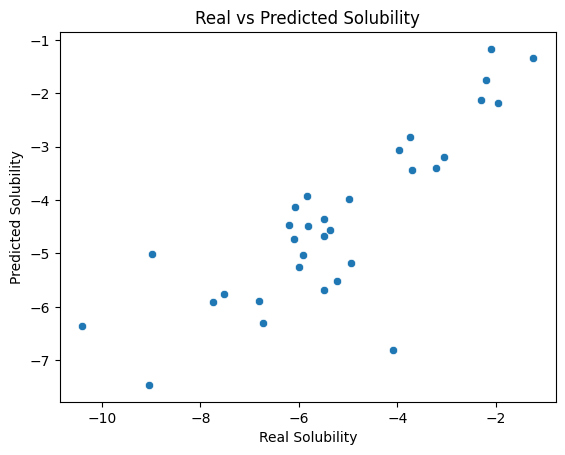

In [ ]:
tmp = pd.DataFrame(data={"y_true":  y_test, "y_proba": y_test_pred})
sns.scatterplot(x="y_true", y="y_proba", data=tmp);
plt.title("Real vs Predicted Solubility")
plt.xlabel("Real Solubility")
plt.ylabel("Predicted Solubility");

Most important features and their percieved values

In [ ]:
# Get feature importances from the trained model
feature_importance = final_model.feature_importance()

# Create a DataFrame to store feature importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Most important features: \n")
print(importance_df.head(10))

print("\n\n")

print('Least Important Features: \n')
print(importance_df.tail(10))

Most important features: 

              Feature  Importance
122           MolLogP         220
4                 qed         174
11   MinPartialCharge         170
58          PEOE_VSA8         148
40      HallKierAlpha         147
44             Kappa3         143
23        BCUT2D_MRHI         142
75         SlogP_VSA3         129
26           BalabanJ         123
17        BCUT2D_MWHI         122



Least Important Features: 

                      Feature  Importance
120         NumSaturatedRings           6
110         NumAliphaticRings           5
111    NumAromaticCarbocycles           5
113          NumAromaticRings           5
108   NumAliphaticCarbocycles           5
109  NumAliphaticHeterocycles           3
85               EState_VSA11           0
118   NumSaturatedCarbocycles           0
81                 SlogP_VSA9           0
68                   SMR_VSA8           0


**Optional: Grid Search (For best hyperparameter)**

In [ ]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

# Define the parameter grid
param_grid = {
    'num_leaves': [50, 60],
    'learning_rate': [0.1, 0.9],
    'feature_fraction': [0.7, 0.65],
    'bagging_fraction': [0.8, 0.85],
    'bagging_freq': [5]
}

best_param = [param_grid['num_leaves'][0], param_grid['learning_rate'][0], param_grid['feature_fraction'][0], param_grid['bagging_fraction'][0],
              param_grid['bagging_freq'][0]]

best_mse = avg_mse

for a in param_grid['num_leaves']:
  for b in param_grid['learning_rate']:
    for c in param_grid['feature_fraction']:
      for d in param_grid['bagging_fraction']:
        for e in param_grid['bagging_freq']:
          params = {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting': 'gbdt',
            'num_leaves': a,
            'learning_rate': b,
            'feature_fraction': c,
            'bagging_fraction': d,
            'bagging_freq': e,
            'verbose': 0
          }

          data = lgb.Dataset(X_train_val, label=y_train_val)

          # Perform cross-validation
          num_folds = 5
          kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
          mse_scores = []

          for train_index, val_index in kf.split(X_train_val):
              X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
              y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]

              train_data = lgb.Dataset(X_train, label=y_train)
              val_data = lgb.Dataset(X_val, label=y_val)

              model = lgb.train(params, train_data, num_boost_round=100, valid_sets=[train_data, val_data], early_stopping_rounds=10)

              y_val_pred = model.predict(X_val)
              mse = mean_squared_error(y_val, y_val_pred)

              mse_scores.append(mse)

          avg_mse = np.mean(mse_scores)

          if avg_mse < best_mse:
            best_mse = avg_mse

            best_param = [a, b, c, d, e]

best_param

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's rmse: 1.55507	valid_1's rmse: 1.45656
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's rmse: 1.41264	valid_1's rmse: 1.33238
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's rmse: 1.30077	valid_1's rmse: 1.23774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's rmse: 1.19113	valid_1's rmse: 1.15948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's rmse: 1.08677	valid_1's rmse: 1.06856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	training's rmse: 1.00393	valid_1's rmse: 0.995106
[Ligh

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's rmse: 1.51261	valid_1's rmse: 1.63098
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's rmse: 1.37771	valid_1's rmse: 1.47784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's rmse: 1.26787	valid_1's rmse: 1.36779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's rmse: 1.17273	valid_1's rmse: 1.26505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's rmse: 1.07298	valid_1's rmse: 1.15281
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	training's rmse: 0.997689	valid_1's rmse: 1.07497
[Ligh

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[19]	training's rmse: 0.390853	valid_1's rmse: 0.491832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	training's rmse: 0.370779	valid_1's rmse: 0.4789
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21]	training's rmse: 0.353931	valid_1's rmse: 0.467914
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22]	training's rmse: 0.339985	valid_1's rmse: 0.458434
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23]	training's rmse: 0.327474	valid_1's rmse: 0.449906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[24]	training's rmse: 0.316499	valid_1's rmse: 0.439998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[25]	training's rmse: 0.30676	valid_1's rmse: 0.434627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[26]	training's rmse: 0.295259	valid_1's rmse: 0.427005
[LightGBM] [Warning] No furthe

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	training's rmse: 0.255102	valid_1's rmse: 0.403864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[31]	training's rmse: 0.249257	valid_1's rmse: 0.398175
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[32]	training's rmse: 0.244334	valid_1's rmse: 0.394235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[33]	training's rmse: 0.238704	valid_1's rmse: 0.389448
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[34]	training's rmse: 0.234066	valid_1's rmse: 0.386916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[35]	training's rmse: 0.228913	valid_1's rmse: 0.381873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[36]	training's rmse: 0.224449	valid_1's rmse: 0.379513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[37]	tra

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[24]	training's rmse: 0.306098	valid_1's rmse: 0.517553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[25]	training's rmse: 0.29444	valid_1's rmse: 0.50941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[26]	training's rmse: 0.283463	valid_1's rmse: 0.504234
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[27]	training's rmse: 0.274123	valid_1's rmse: 0.500247
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[28]	training's rmse: 0.265053	valid_1's rmse: 0.493853
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[29]	training's rmse: 0.2573	valid_1's rmse: 0.489246
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	training's rmse: 0.249939	valid_1's rmse: 0.487037
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[31]	trainin

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[34]	training's rmse: 0.223356	valid_1's rmse: 0.424177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[35]	training's rmse: 0.218819	valid_1's rmse: 0.421241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[36]	training's rmse: 0.213315	valid_1's rmse: 0.417122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[37]	training's rmse: 0.207982	valid_1's rmse: 0.41438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[38]	training's rmse: 0.203668	valid_1's rmse: 0.412371
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[39]	training's rmse: 0.199311	valid_1's rmse: 0.410639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	training's rmse: 0.195835	valid_1's rmse: 0.408867
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[41]	training's rmse: 0.19202	valid_1's rmse: 0.40737
[LightGBM] [Warning] No furthe

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[28]	training's rmse: 0.287223	valid_1's rmse: 0.366249
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[29]	training's rmse: 0.278689	valid_1's rmse: 0.361448
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	training's rmse: 0.270297	valid_1's rmse: 0.356661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[31]	training's rmse: 0.262868	valid_1's rmse: 0.353439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[32]	training's rmse: 0.257554	valid_1's rmse: 0.353275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[33]	training's rmse: 0.252264	valid_1's rmse: 0.351054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[34]	training's rmse: 0.247192	valid_1's rmse: 0.349873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[35]	training's rmse: 0.243066	valid_1's rmse: 0.349399
[LightGBM] [Warning] No fur

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[5]	training's rmse: 1.06649	valid_1's rmse: 1.08934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	training's rmse: 0.983122	valid_1's rmse: 1.01396
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	training's rmse: 0.896203	valid_1's rmse: 0.931927
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8]	training's rmse: 0.831464	valid_1's rmse: 0.872321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9]	training's rmse: 0.770334	valid_1's rmse: 0.814555
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	training's rmse: 0.706383	valid_1's rmse: 0.758562
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11]	training's rmse: 0.656608	valid_1's rmse: 0.717107
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12]	training's rmse: 0.604803	valid_1's rmse: 0.672588
[LightGBM] [Warning] No further spl

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's rmse: 1.38613	valid_1's rmse: 1.41746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's rmse: 1.27291	valid_1's rmse: 1.31322
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's rmse: 1.17091	valid_1's rmse: 1.2171
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's rmse: 1.06612	valid_1's rmse: 1.11774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	training's rmse: 0.987057	valid_1's rmse: 1.04789
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	training's rmse: 0.90124	valid_1's rmse: 0.964245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8]	training's rmse: 0.838026	valid_1's rmse: 0.906674
[LightGBM] [Warning] No further splits 

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[41]	training's rmse: 0.189633	valid_1's rmse: 0.446633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[42]	training's rmse: 0.185783	valid_1's rmse: 0.444073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[43]	training's rmse: 0.182123	valid_1's rmse: 0.443832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[44]	training's rmse: 0.179369	valid_1's rmse: 0.443447
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[45]	training's rmse: 0.176875	valid_1's rmse: 0.44309
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[46]	training's rmse: 0.173622	valid_1's rmse: 0.440176
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[47]	training's rmse: 0.170657	valid_1's rmse: 0.438878
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[48]	training's rmse: 0.167954	valid_1's rmse: 0.437995
[LightGBM] [Warning] No furt

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[37]	training's rmse: 0.229836	valid_1's rmse: 0.449704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[38]	training's rmse: 0.224806	valid_1's rmse: 0.446738
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[39]	training's rmse: 0.220055	valid_1's rmse: 0.444611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	training's rmse: 0.215778	valid_1's rmse: 0.441417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[41]	training's rmse: 0.212271	valid_1's rmse: 0.439802
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[42]	training's rmse: 0.209024	valid_1's rmse: 0.439109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[43]	training's rmse: 0.205882	valid_1's rmse: 0.436859
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[44]	training's rmse: 0.203324	valid_1's rmse: 0.4345
[LightGBM] [Warning] No furth

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[34]	training's rmse: 0.267468	valid_1's rmse: 0.35318
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[35]	training's rmse: 0.263309	valid_1's rmse: 0.351604
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[36]	training's rmse: 0.258322	valid_1's rmse: 0.347737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[37]	training's rmse: 0.254177	valid_1's rmse: 0.34517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[38]	training's rmse: 0.249644	valid_1's rmse: 0.342473
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[39]	training's rmse: 0.244959	valid_1's rmse: 0.33891
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	training's rmse: 0.241339	valid_1's rmse: 0.336114
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[41]	training's rmse: 0.23763	valid_1's rmse: 0.3332
[LightGBM] [Warning] No further s

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[34]	training's rmse: 0.243404	valid_1's rmse: 0.402557
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[35]	training's rmse: 0.238346	valid_1's rmse: 0.401186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[36]	training's rmse: 0.233383	valid_1's rmse: 0.398496
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[37]	training's rmse: 0.229836	valid_1's rmse: 0.395143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[38]	training's rmse: 0.225504	valid_1's rmse: 0.392045
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[39]	training's rmse: 0.22149	valid_1's rmse: 0.38981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	training's rmse: 0.217559	valid_1's rmse: 0.387339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[41]	train

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[44]	training's rmse: 0.20005	valid_1's rmse: 0.377459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[45]	training's rmse: 0.197648	valid_1's rmse: 0.376585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[46]	training's rmse: 0.195846	valid_1's rmse: 0.376366
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[47]	training's rmse: 0.192655	valid_1's rmse: 0.375099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[48]	training's rmse: 0.191009	valid_1's rmse: 0.374901
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[49]	training's rmse: 0.189919	valid_1's rmse: 0.375606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	training's rmse: 0.188267	valid_1's rmse: 0.374063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[51]	trai

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's rmse: 1.53236	valid_1's rmse: 1.55297
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's rmse: 1.40922	valid_1's rmse: 1.44989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's rmse: 1.29832	valid_1's rmse: 1.3581
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's rmse: 1.19427	valid_1's rmse: 1.2675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's rmse: 1.08908	valid_1's rmse: 1.16437
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	training's rmse: 1.00671	valid_1's rmse: 1.09519
[LightGB

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[8]	training's rmse: 0.860362	valid_1's rmse: 0.863169
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9]	training's rmse: 0.795553	valid_1's rmse: 0.824033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	training's rmse: 0.730535	valid_1's rmse: 0.769336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11]	training's rmse: 0.681703	valid_1's rmse: 0.741516
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12]	training's rmse: 0.627731	valid_1's rmse: 0.69857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13]	training's rmse: 0.586992	valid_1's rmse: 0.666897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14]	training's rmse: 0.548989	valid_1's rmse: 0.644121
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15]	training's rmse: 0.509031	valid_1's rmse: 0.613573
[LightGBM] [Warning] No furthe

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[19]	training's rmse: 0.416969	valid_1's rmse: 0.477699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	training's rmse: 0.396752	valid_1's rmse: 0.454641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21]	training's rmse: 0.379832	valid_1's rmse: 0.438094
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22]	training's rmse: 0.363987	valid_1's rmse: 0.423419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23]	training's rmse: 0.349164	valid_1's rmse: 0.407741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[24]	training's rmse: 0.336778	valid_1's rmse: 0.397347
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[25]	training's rmse: 0.325076	valid_1's rmse: 0.388693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[26]	training's rmse: 0.313884	valid_1's rmse: 0.376754
[LightGBM] [Warning] No fu

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's rmse: 1.53089	valid_1's rmse: 1.52227
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's rmse: 1.4068	valid_1's rmse: 1.40006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's rmse: 1.29402	valid_1's rmse: 1.29609
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's rmse: 1.1892	valid_1's rmse: 1.19178
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's rmse: 1.08129	valid_1's rmse: 1.09144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	training's rmse: 1.00016	valid_1's rmse: 1.0173
[LightGBM

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's rmse: 1.52697	valid_1's rmse: 1.55049
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's rmse: 1.40203	valid_1's rmse: 1.43477
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's rmse: 1.28907	valid_1's rmse: 1.32648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's rmse: 1.18861	valid_1's rmse: 1.23003
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's rmse: 1.08314	valid_1's rmse: 1.13124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	training's rmse: 1.00399	valid_1's rmse: 1.05998
[Light

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's rmse: 1.52956	valid_1's rmse: 1.55266
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's rmse: 1.40473	valid_1's rmse: 1.44862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's rmse: 1.2929	valid_1's rmse: 1.36245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's rmse: 1.19315	valid_1's rmse: 1.28303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's rmse: 1.08569	valid_1's rmse: 1.1765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	training's rmse: 1.00244	valid_1's rmse: 1.1096
[LightGBM

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's rmse: 0.731849	valid_1's rmse: 0.866693
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's rmse: 0.557291	valid_1's rmse: 0.739863
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's rmse: 0.515671	valid_1's rmse: 0.703969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's rmse: 0.492792	valid_1's rmse: 0.729021
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's rmse: 0.473777	valid_1's rmse: 0.743832
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's rmse: 0.746739	valid_1's rmse: 0.775661
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's rmse: 0.567637	valid_1's rmse: 0.696859
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's rmse: 0.495181	valid_1's rmse: 0.673685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's rmse: 0.457408	valid_1's rmse: 0.663533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's rmse: 0.42186	valid_1's rmse: 0.654271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	training's rmse: 0.387046	valid_1's rmse: 0.66

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's rmse: 0.708245	valid_1's rmse: 0.843991
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's rmse: 0.50918	valid_1's rmse: 0.733791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's rmse: 0.44857	valid_1's rmse: 0.733484
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's rmse: 0.426034	valid_1's rmse: 0.732481
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's rmse: 0.40663	valid_1's rmse: 0.732498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	training's rmse: 0.370877	valid_1's rmse: 0.7521

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21]	training's rmse: 0.147632	valid_1's rmse: 0.75336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22]	training's rmse: 0.138563	valid_1's rmse: 0.750748
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23]	training's rmse: 0.132128	valid_1's rmse: 0.749601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[24]	training's rmse: 0.125348	valid_1's rmse: 0.756593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[25]	training's rmse: 0.123155	valid_1's rmse: 0.756023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[26]	training's rmse: 0.116842	valid_1's rmse: 0.759081
Early stopping, best iteration is:
[16]	training's rmse: 0.185438	valid_1's rmse: 0.738186
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001629 seconds.
You can set `for

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's rmse: 0.546484	valid_1's rmse: 0.748553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's rmse: 0.46889	valid_1's rmse: 0.712618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's rmse: 0.425937	valid_1's rmse: 0.698613
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's rmse: 0.387558	valid_1's rmse: 0.663045
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	training's rmse: 0.351013	valid_1's rmse: 0.678127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	training's rmse: 0.325529	valid_1's rmse: 0.686837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8]	training's rmse: 0.303718	valid_1's rmse: 0.696394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9]	training's r

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	training's rmse: 0.337675	valid_1's rmse: 0.679561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	training's rmse: 0.308715	valid_1's rmse: 0.697332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8]	training's rmse: 0.287341	valid_1's rmse: 0.704687
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9]	training's rmse: 0.268413	valid_1's rmse: 0.734439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	training's rmse: 0.252158	valid_1's rmse: 0.744131
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11]	training's rmse: 0.235743	valid_1's rmse: 0.740476
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12]	training's rmse: 0.218896	valid_1's rmse: 0.733307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13]	trainin

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's rmse: 0.736653	valid_1's rmse: 0.869409
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's rmse: 0.560328	valid_1's rmse: 0.75808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's rmse: 0.504533	valid_1's rmse: 0.719276
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's rmse: 0.456338	valid_1's rmse: 0.723455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's rmse: 0.437228	valid_1's rmse: 0.731255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	training's rmse: 0.390103	valid_1's rmse: 0.73

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14]	training's rmse: 0.201628	valid_1's rmse: 0.671082
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15]	training's rmse: 0.192408	valid_1's rmse: 0.674663
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16]	training's rmse: 0.178594	valid_1's rmse: 0.658223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17]	training's rmse: 0.167291	valid_1's rmse: 0.663449
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18]	training's rmse: 0.155313	valid_1's rmse: 0.666377
Early stopping, best iteration is:
[8]	training's rmse: 0.308125	valid_1's rmse: 0.5882
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's rm

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[15]	training's rmse: 0.17627	valid_1's rmse: 0.686044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16]	training's rmse: 0.162769	valid_1's rmse: 0.68606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17]	training's rmse: 0.152563	valid_1's rmse: 0.684807
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18]	training's rmse: 0.14639	valid_1's rmse: 0.673366
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19]	training's rmse: 0.139072	valid_1's rmse: 0.673786
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	training's rmse: 0.13366	valid_1's rmse: 0.670556
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21]	training's rmse: 0.124999	valid_1's rmse: 0.665541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22]	training's rmse: 0.119952	valid_1's rmse: 0.664458
[LightGBM] [Warning] No further

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's rmse: 0.669311	valid_1's rmse: 0.803565
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's rmse: 0.524397	valid_1's rmse: 0.728679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's rmse: 0.453838	valid_1's rmse: 0.736457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's rmse: 0.418946	valid_1's rmse: 0.71508
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's rmse: 0.391526	valid_1's rmse: 0.726135
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	training's rmse: 0.36283	valid_1's rmse: 0.728

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[19]	training's rmse: 0.393347	valid_1's rmse: 0.536294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	training's rmse: 0.373729	valid_1's rmse: 0.522228
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21]	training's rmse: 0.354887	valid_1's rmse: 0.509095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22]	training's rmse: 0.337828	valid_1's rmse: 0.498921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23]	training's rmse: 0.322385	valid_1's rmse: 0.488016
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[24]	training's rmse: 0.309722	valid_1's rmse: 0.485187
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[25]	training's rmse: 0.298683	valid_1's rmse: 0.477608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[26]	training's rmse: 0.287137	valid_1's rmse: 0.471183
[LightGBM] [Warning] No fur

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	training's rmse: 0.914858	valid_1's rmse: 0.980363
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8]	training's rmse: 0.851094	valid_1's rmse: 0.914221
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9]	training's rmse: 0.792495	valid_1's rmse: 0.854977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	training's rmse: 0.731874	valid_1's rmse: 0.786494
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11]	training's rmse: 0.684458	valid_1's rmse: 0.74063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12]	training's rmse: 0.636059	valid_1's rmse: 0.691849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13]	training's rmse: 0.597707	valid_1's rmse: 0.656396
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14]	trainin

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19]	training's rmse: 0.390853	valid_1's rmse: 0.491832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	training's rmse: 0.370779	valid_1's rmse: 0.4789
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21]	training's rmse: 0.353931	valid_1's rmse: 0.467914
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22]	training's rmse: 0.339985	valid_1's rmse: 0.458434
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23]	training's rmse: 0.327474	valid_1's rmse: 0.449906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[24]	training's rmse: 0.316499	valid_1's rmse: 0.439998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[25]	training's rmse: 0.30676	valid_1's rmse: 0.434627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[26]	traini

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[29]	training's rmse: 0.262035	valid_1's rmse: 0.405944
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	training's rmse: 0.255102	valid_1's rmse: 0.403864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[31]	training's rmse: 0.249257	valid_1's rmse: 0.398175
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[32]	training's rmse: 0.244334	valid_1's rmse: 0.394235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[33]	training's rmse: 0.238704	valid_1's rmse: 0.389448
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[34]	training's rmse: 0.234066	valid_1's rmse: 0.386916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[35]	training's rmse: 0.228913	valid_1's rmse: 0.381873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[36]	tra

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[26]	training's rmse: 0.283463	valid_1's rmse: 0.504234
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[27]	training's rmse: 0.274123	valid_1's rmse: 0.500247
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[28]	training's rmse: 0.265053	valid_1's rmse: 0.493853
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[29]	training's rmse: 0.2573	valid_1's rmse: 0.489246
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	training's rmse: 0.249939	valid_1's rmse: 0.487037
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[31]	training's rmse: 0.24313	valid_1's rmse: 0.482833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[32]	training's rmse: 0.236973	valid_1's rmse: 0.478221
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[33]	traini

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[31]	training's rmse: 0.240091	valid_1's rmse: 0.433264
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[32]	training's rmse: 0.234532	valid_1's rmse: 0.430543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[33]	training's rmse: 0.229033	valid_1's rmse: 0.42657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[34]	training's rmse: 0.223356	valid_1's rmse: 0.424177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[35]	training's rmse: 0.218819	valid_1's rmse: 0.421241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[36]	training's rmse: 0.213315	valid_1's rmse: 0.417122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[37]	training's rmse: 0.207982	valid_1's rmse: 0.41438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[38]	train

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19]	training's rmse: 0.409242	valid_1's rmse: 0.466766
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	training's rmse: 0.390348	valid_1's rmse: 0.447374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21]	training's rmse: 0.372027	valid_1's rmse: 0.432258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22]	training's rmse: 0.356027	valid_1's rmse: 0.419107
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23]	training's rmse: 0.342028	valid_1's rmse: 0.406802
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[24]	training's rmse: 0.329817	valid_1's rmse: 0.397784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[25]	training's rmse: 0.31838	valid_1's rmse: 0.388094
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[26]	trai

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's rmse: 1.53089	valid_1's rmse: 1.52227
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's rmse: 1.38955	valid_1's rmse: 1.38963
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's rmse: 1.27675	valid_1's rmse: 1.28284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's rmse: 1.17197	valid_1's rmse: 1.18705
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's rmse: 1.06649	valid_1's rmse: 1.08934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	training's rmse: 0.983122	valid_1's rmse: 1.01396
[Ligh

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's rmse: 1.52697	valid_1's rmse: 1.55049
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's rmse: 1.38613	valid_1's rmse: 1.41746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's rmse: 1.27291	valid_1's rmse: 1.31322
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's rmse: 1.17091	valid_1's rmse: 1.2171
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's rmse: 1.06612	valid_1's rmse: 1.11774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	training's rmse: 0.987057	valid_1's rmse: 1.04789
[Light

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's rmse: 1.52956	valid_1's rmse: 1.55266
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's rmse: 1.38903	valid_1's rmse: 1.41465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's rmse: 1.27701	valid_1's rmse: 1.31884
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's rmse: 1.17318	valid_1's rmse: 1.23433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's rmse: 1.06827	valid_1's rmse: 1.13146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	training's rmse: 0.98499	valid_1's rmse: 1.0617
[LightG

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's rmse: 1.55549	valid_1's rmse: 1.45661
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's rmse: 1.4312	valid_1's rmse: 1.34578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's rmse: 1.32051	valid_1's rmse: 1.24114
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's rmse: 1.22106	valid_1's rmse: 1.16273
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's rmse: 1.11431	valid_1's rmse: 1.06574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	training's rmse: 1.03059	valid_1's rmse: 1.01342
[LightG

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's rmse: 1.51249	valid_1's rmse: 1.6311
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's rmse: 1.39319	valid_1's rmse: 1.50477
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's rmse: 1.28914	valid_1's rmse: 1.40109
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's rmse: 1.18991	valid_1's rmse: 1.29944
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's rmse: 1.08838	valid_1's rmse: 1.18523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	training's rmse: 1.00646	valid_1's rmse: 1.0997
[LightGB

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's rmse: 1.53263	valid_1's rmse: 1.52655
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's rmse: 1.40884	valid_1's rmse: 1.40258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's rmse: 1.29613	valid_1's rmse: 1.30004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's rmse: 1.19574	valid_1's rmse: 1.2068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's rmse: 1.08883	valid_1's rmse: 1.10698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	training's rmse: 1.00702	valid_1's rmse: 1.03149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	training's rmse: 0.919301	valid_1's rmse: 0.951588
[LightGBM] [Warning] No further splits wit

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8]	training's rmse: 0.856538	valid_1's rmse: 0.915333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9]	training's rmse: 0.792765	valid_1's rmse: 0.857331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	training's rmse: 0.72901	valid_1's rmse: 0.795739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11]	training's rmse: 0.679935	valid_1's rmse: 0.747005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12]	training's rmse: 0.630378	valid_1's rmse: 0.704476
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13]	training's rmse: 0.593019	valid_1's rmse: 0.674071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14]	training's rmse: 0.55676	valid_1's rmse: 0.647827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15]	trainin

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[5]	training's rmse: 1.08908	valid_1's rmse: 1.16437
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	training's rmse: 1.00671	valid_1's rmse: 1.09519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	training's rmse: 0.919671	valid_1's rmse: 1.01116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8]	training's rmse: 0.854811	valid_1's rmse: 0.958581
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9]	training's rmse: 0.794509	valid_1's rmse: 0.908955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	training's rmse: 0.730754	valid_1's rmse: 0.847981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11]	training's rmse: 0.679934	valid_1's rmse: 0.810303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12]	training's rmse: 0.627999	valid_1's rmse: 0.761417
[LightGBM] [Warning] No further split

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[15]	training's rmse: 0.509031	valid_1's rmse: 0.613573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16]	training's rmse: 0.475341	valid_1's rmse: 0.589951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17]	training's rmse: 0.446207	valid_1's rmse: 0.568507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18]	training's rmse: 0.420858	valid_1's rmse: 0.555987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19]	training's rmse: 0.397555	valid_1's rmse: 0.539818
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	training's rmse: 0.376133	valid_1's rmse: 0.524393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21]	training's rmse: 0.355774	valid_1's rmse: 0.51176
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22]	training's rmse: 0.33896	valid_1's rmse: 0.499205
[LightGBM] [Warning] No furth

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[7]	training's rmse: 0.920068	valid_1's rmse: 0.993133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8]	training's rmse: 0.853968	valid_1's rmse: 0.925177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9]	training's rmse: 0.793012	valid_1's rmse: 0.865889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	training's rmse: 0.730904	valid_1's rmse: 0.801179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11]	training's rmse: 0.683596	valid_1's rmse: 0.749906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12]	training's rmse: 0.633306	valid_1's rmse: 0.697304
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13]	training's rmse: 0.595402	valid_1's rmse: 0.661548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14]	training's rmse: 0.558898	valid_1's rmse: 0.624667
[LightGBM] [Warning] No furthe

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21]	training's rmse: 0.352893	valid_1's rmse: 0.486238
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22]	training's rmse: 0.337386	valid_1's rmse: 0.478714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23]	training's rmse: 0.324458	valid_1's rmse: 0.470397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[24]	training's rmse: 0.312857	valid_1's rmse: 0.463818
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[25]	training's rmse: 0.302542	valid_1's rmse: 0.456783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[26]	training's rmse: 0.291177	valid_1's rmse: 0.449424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[27]	training's rmse: 0.281015	valid_1's rmse: 0.443571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[28]	tra

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14]	training's rmse: 0.551883	valid_1's rmse: 0.655183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15]	training's rmse: 0.515788	valid_1's rmse: 0.624525
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16]	training's rmse: 0.482231	valid_1's rmse: 0.595961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17]	training's rmse: 0.452233	valid_1's rmse: 0.569769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18]	training's rmse: 0.428147	valid_1's rmse: 0.556458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19]	training's rmse: 0.403998	valid_1's rmse: 0.535065
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	training's rmse: 0.382077	valid_1's rmse: 0.517117
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21]	tra

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's rmse: 1.52956	valid_1's rmse: 1.55266
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's rmse: 1.40473	valid_1's rmse: 1.44862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's rmse: 1.2929	valid_1's rmse: 1.36245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's rmse: 1.19315	valid_1's rmse: 1.28303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's rmse: 1.08569	valid_1's rmse: 1.1765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	training's rmse: 1.00244	valid_1's rmse: 1.1096
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	training's rmse: 0.915015	valid_1's rmse: 1.02512
[LightGBM] [Warning] No further splits with p

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's rmse: 0.731849	valid_1's rmse: 0.866693
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's rmse: 0.557291	valid_1's rmse: 0.739863
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's rmse: 0.515671	valid_1's rmse: 0.703969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's rmse: 0.492792	valid_1's rmse: 0.729021
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's rmse: 0.473777	valid_1's rmse: 0.743832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	training's rmse: 0.425986	valid_1's rmse: 0.7

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's rmse: 0.746739	valid_1's rmse: 0.775661
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's rmse: 0.567637	valid_1's rmse: 0.696859
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's rmse: 0.495181	valid_1's rmse: 0.673685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's rmse: 0.457408	valid_1's rmse: 0.663533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's rmse: 0.42186	valid_1's rmse: 0.654271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	training's rmse: 0.387046	valid_1's rmse: 0.66

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's rmse: 0.70092	valid_1's rmse: 0.981683
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's rmse: 0.498417	valid_1's rmse: 0.765198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's rmse: 0.434628	valid_1's rmse: 0.796354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's rmse: 0.388706	valid_1's rmse: 0.770699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's rmse: 0.363288	valid_1's rmse: 0.777481
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	training's rmse: 0.329516	valid_1's rmse: 0.74

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's rmse: 0.683765	valid_1's rmse: 0.81414
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's rmse: 0.514575	valid_1's rmse: 0.752394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's rmse: 0.450074	valid_1's rmse: 0.752003
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's rmse: 0.403532	valid_1's rmse: 0.72047
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's rmse: 0.367659	valid_1's rmse: 0.711654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	training's rmse: 0.332044	valid_1's rmse: 0.714

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	training's rmse: 0.274038	valid_1's rmse: 0.686679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11]	training's rmse: 0.249146	valid_1's rmse: 0.701384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12]	training's rmse: 0.232586	valid_1's rmse: 0.708497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13]	training's rmse: 0.21766	valid_1's rmse: 0.706463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14]	training's rmse: 0.206728	valid_1's rmse: 0.714469
Early stopping, best iteration is:
[4]	training's rmse: 0.411485	valid_1's rmse: 0.651736
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's r

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's rmse: 0.655767	valid_1's rmse: 0.954237
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's rmse: 0.476711	valid_1's rmse: 0.813099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's rmse: 0.41337	valid_1's rmse: 0.778597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's rmse: 0.378955	valid_1's rmse: 0.771761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's rmse: 0.342394	valid_1's rmse: 0.768352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	training's rmse: 0.31504	valid_1's rmse: 0.775133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	training's rmse: 0.294123	valid_1's rmse: 0.78509
[LightGBM] [Warning] No further 

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's rmse: 0.736653	valid_1's rmse: 0.869409
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's rmse: 0.560328	valid_1's rmse: 0.75808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's rmse: 0.504533	valid_1's rmse: 0.719276
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's rmse: 0.456338	valid_1's rmse: 0.723455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's rmse: 0.437228	valid_1's rmse: 0.731255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	training's rmse: 0.390103	valid_1's rmse: 0.73

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	training's rmse: 0.314007	valid_1's rmse: 0.631811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11]	training's rmse: 0.291899	valid_1's rmse: 0.629733
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12]	training's rmse: 0.277313	valid_1's rmse: 0.635163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13]	training's rmse: 0.26567	valid_1's rmse: 0.63163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14]	training's rmse: 0.251878	valid_1's rmse: 0.613375
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15]	training's rmse: 0.242338	valid_1's rmse: 0.618664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16]	training's rmse: 0.229836	valid_1's rmse: 0.613913
Early stopping, best iteration is:
[6]	training's rmse: 0.399726	valid_1's rmse: 0.60

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's rmse: 0.679193	valid_1's rmse: 0.788703
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's rmse: 0.529604	valid_1's rmse: 0.671283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's rmse: 0.472643	valid_1's rmse: 0.63316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's rmse: 0.433657	valid_1's rmse: 0.620217
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's rmse: 0.409261	valid_1's rmse: 0.619227
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	training's rmse: 0.365232	valid_1's rmse: 0.606495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	training's rmse: 0.334151	valid_1's rmse: 0.590601
[LightGBM] [Warning] No furthe

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21]	training's rmse: 0.124999	valid_1's rmse: 0.665541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22]	training's rmse: 0.119952	valid_1's rmse: 0.664458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23]	training's rmse: 0.109995	valid_1's rmse: 0.661125
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[24]	training's rmse: 0.105932	valid_1's rmse: 0.659912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[25]	training's rmse: 0.100489	valid_1's rmse: 0.661922
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[26]	training's rmse: 0.0942349	valid_1's rmse: 0.661779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[27]	training's rmse: 0.0878948	valid_1's rmse: 0.663057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[28]	

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's rmse: 0.499566	valid_1's rmse: 0.688387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's rmse: 0.432428	valid_1's rmse: 0.676573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's rmse: 0.392628	valid_1's rmse: 0.678301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	training's rmse: 0.356229	valid_1's rmse: 0.67504
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	training's rmse: 0.324963	valid_1's rmse: 0.669993
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8]	training's rmse: 0.300776	valid_1's rmse: 0.686679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9]	training's rmse: 0.27802	valid_1's rmse: 0.691085
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	training's r

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's rmse: 0.655767	valid_1's rmse: 0.954237
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's rmse: 0.491342	valid_1's rmse: 0.894931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's rmse: 0.419985	valid_1's rmse: 0.849245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's rmse: 0.370734	valid_1's rmse: 0.819903
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's rmse: 0.338489	valid_1's rmse: 0.80413
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	training's rmse: 0.307809	valid_1's rmse: 0.813451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	training's rmse: 0.280953	valid_1's rmse: 0.796649
[LightGBM] [Warning] No furthe

[50, 0.1, 0.7, 0.8, 5]